In [1]:
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 14, 10
plt.rcParams['lines.linewidth'] = 1.5

font = {'weight' : 'normal',
      'size'   : 15}

plt.rc('font', **font)

In [2]:
#multi param and multi forcing method

def forcing_to_conc(RF_in, 
                   RF_ext = None, 
                   RF_ext_in = False,
                   param_array = np.array([5.396,278.])):
    
   # --- PARAMETERS ---
    #param_array,
        # 1) a = logarithmic forcing efficacy in W/m-2/alog(2). Default = 5.396 W/m^2
        # 2) Cpreind = preindustrial CO2 concentration in ppmv (278.)
    # RF_ext = external radaitive forcing profile which contributes but shouldn't add to the equivalent CO2 concentrations
    # RE_ext_in = boolean, allows user to include or not include the contribution to RF of other (non-anthropogenic) sources
   #---  ----  ---  ---
    
   #Initializing parameters
    a = param_array[...,0]
    C_preind = param_array[...,1]
    if RF_in.ndim == 1:
        rf_dim = 1
        RF_in = RF_in[np.newaxis]
    else:
        rf_dim = RF_in.shape[0]
    
   # Initializing arrays
    # Create array to hold concentration values
    C = np.zeros((RF_in.shape[0],a.size, RF_in.shape[-1]))
    
    # Check inputs are of the same size if external forcing data is also provided
    if RF_ext_in == True:
        if RF_in.shape != RF_ext.shape:
            print 'The inputs RF_in and RF_ext are not of the same shape!'
    elif RF_ext_in == False:
        RF_ext = np.zeros(RF_in.shape)
    
   # Compute required co2 concentration to produce inputted logarithmic forcing
    for i in range(0, RF_in.shape[-1]):
        C[...,i]=np.exp((RF_in[:,np.newaxis,i]-RF_ext[:,np.newaxis,i])/a)*C_preind
    
    return C

In [3]:
    if C.shape[1] == 1:
        if C.shape[0] == 1:
            return C[0,0,:]
        else:
            return C[:,0,:]
    elif C.shape[0] == 1:
        return C[0,:,:]
    else:
        return C

SyntaxError: 'return' outside function (<ipython-input-3-5277c578dc79>, line 3)

ValueError: x and y must have same first dimension, but have shapes (267,) and (1, 267)

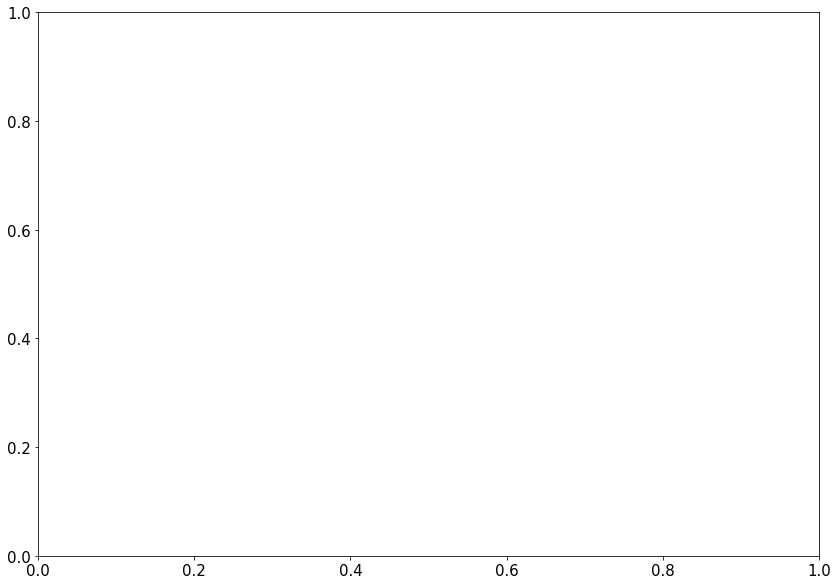

In [5]:
#multi forcing single parameter set run through

#import piers data for total anthro RF
rf_anthro_piers = np.loadtxt("rf_a_reord.txt")
rf_anthro_piers = rf_anthro_piers.reshape((200,267))

C = forcing_to_conc(rf_anthro_piers)

for i in range(C.shape[0]):
    plt.plot(np.arange(1750,2017), C[i,:], linewidth = 0.1, color = 'royalblue')
    
C_median = forcing_to_conc(rf_anthro_piers[90,:])

plt.plot(np.arange(1750,2017), C_median, color = 'red', linewidth = 2)

In [6]:
from scipy.optimize import root
import scipy.ndimage.filters as filters1

def iirf100_interp_funct(alpha,a,tau,targ_iirf100):
    iirf100_arr = alpha*(np.sum(a*tau*(1.0 - np.exp(-100.0/(tau*alpha)))))
    return iirf100_arr   -  targ_iirf100

def iirf100_interp_funct_multi_rf(alpha,a,tau,targ_iirf100):
    iirf100_arr = alpha*(np.sum((a*tau*(1.0 - np.exp(-100.0/(tau*alpha[:,np.newaxis])))),axis=1))
    return iirf100_arr   -  targ_iirf100

# Define function which does inversion of carbon dioxide concentration to emissions of carbon
def conc_to_emissions(co2_conc, T,
              input_params=np.array([1000000,381.330,34.7850,4.12370,0.21787,0.22896,0.28454,0.26863,0.471,32.40,0.019,4.165,97.,278]),
              in_state=np.array([0.0,0.0,0.0,0.0,0.0,0.0,0.0])):
    
    if input_params.ndim==1:
        p_dims = 1
        input_params = input_params[np.newaxis]
    else:
        p_dims = input_params.shape[0]
    
                        
    t_const = input_params[...,0:4]
    pool_splits = input_params[...,4:8]
    GtC_2_ppmv = input_params[...,8]
    r0 = input_params[...,9]
    rC = input_params[...,10]
    rT = input_params[...,11]
    iirf100_max = input_params[...,12]
    Cpreind = input_params[...,13]
    year_smoothing = 5
    tstep = 1.0
    
   # PARAMETERS #
    # co2_conc = inputted co2 forcing equivalent concentration profile
    # T_input = inputted temperature profile for given concentration profile
    # t_const = time constants for the different carbon pools
    # pool_splits = how a unit mass of carbon is split between the pools
    # r0 = 100-year integrated airborne fraction (iIRF100) in the initial equilibrium climate for an infinintesimal pulse
    # rC = sensitivity of iIRF100 to cumulative land-ocean carbon uptake, in years/GtC
    # rT = temperature sensitivity of iIRF100 in years/K
    # iirf100_max = maximum value of the iIRF100 we can calculate (saturates at this value if found to be above)
    # Cpreind = pre-industrial CO2 concentration
    # tstep = timestep between interations of code. Default = 1 yr, never tried for other
    # in_state = input state of the different vectors being calcualted
    
   #NOTE: Myles parameters set:
    #t_const = np.array([1.e8,381.330,34.7850,4.12370])
    #pool_splits = np.array([0.21787,0.22896,0.28454,0.26863])
    #r0 = 35.
    #rC = 0.02
    #rT = 4.5
    #iirf100_max = 95.
    
    # --- SET UP OUTPUT TIMESERIES VARIABLES --- #
    if T.ndim == 2:
        T = T[:,np.newaxis,:]
    
   #initialize the carbon pools, emissions, accumulated carbon and iIRF100 vectors. 
    #Give an intial guess of alpha for root function to work from.
    rf_dims = T.shape[0]
    integ_len = T.shape[2]
    C_comp = np.zeros((T.shape[0],T.shape[1],T.shape[2], 4))
    E = np.zeros(T.shape)
    E_smooth = np.zeros(T.shape)
    C_acc = np.zeros(T.shape)
    iirf100 = np.zeros(T.shape)
    alph_t = np.zeros(T.shape)
    
   ###---------FIRST TIMESTEP----------
    #set the initial values of key parameters as the in_state values, default = zeros.
    C_comp_pre = in_state[...,0:4]
    C_pre = np.sum(C_comp_pre) + Cpreind
    T_j_pre = in_state[...,4:6]
    C_acc_pre = in_state[...,6]

    # Calculate the parametrised iIRF100 and check if it is over the maximum allowed value
    iirf100[...,0] = r0 + rC*C_acc[...,0] + rT*T[...,0]
    for i in range(0,rf_dims):
        for j in range(0,p_dims):
            if iirf100[i,j,0] >= iirf100_max[j]:
                iirf100[i,j,0] = iirf100_max[j]
    
    #find the value of alpha
    if rf_dims == 1:
        for j in range(0,p_dims):
            alph_t[0,j,0] = (root(iirf100_interp_funct,0.16,args=(pool_splits[j],t_const[j],iirf100[0,j,0])))['x']
    else:
        for i in range(0,rf_dims):
            alph_t[i,:,0] = (root(iirf100_interp_funct_multi_rf,0.16,args=(pool_splits,t_const,iirf100[i,:,0])))['x']
        
    #compute the carbon in each pool
    C_comp[...,0,:] = C_comp_pre*np.exp((-tstep)/(alph_t[...,0,np.newaxis]*t_const))
    
    #compute the emissions required to give change in CO2 concentration
    E[...,0] = (co2_conc[...,0] - np.sum(C_comp[...,0,:],-1) - C_pre) / (alph_t[...,0]*np.sum(pool_splits*t_const*(1-np.exp((-tstep)/(alph_t[...,0,np.newaxis]*t_const))),-1)*GtC_2_ppmv)
    
    #recompute the distribution of carbon in each pool for better estimation of emissions in next timestep
    C_comp[...,0,:] = C_comp[...,0,:] + alph_t[...,0,np.newaxis]*pool_splits*t_const*E[...,0,np.newaxis]*GtC_2_ppmv*(1-np.exp((-tstep)/(alph_t[...,0,np.newaxis]*t_const)))
    
    #calculate the accumulated carbon in the land and oceans
    C_acc[...,0] =  C_acc_pre + E[...,0]*tstep - ((co2_conc[...,0]-C_pre)/GtC_2_ppmv)
    
   ###----------REST OF RUN-------------
    for x in range(1, integ_len):
        #estimate the value of iIRF100, given the temperature and accumulated carbon in previous timestep
        iirf100[...,x] = r0 + rC*C_acc[...,(x-1)] + rT*T[...,(x-1)]
        for i in range(0,rf_dims):
            for j in range(0,p_dims):
                if iirf100[i,j,x] >= iirf100_max[j]:
                    iirf100[i,j,x] = iirf100_max[j]
        
        #calculate the value of alpha using scipys root finder
        if rf_dims == 1:
            for j in range(0,p_dims):
                alph_t[0,j,x] = (root(iirf100_interp_funct,alph_t[0,j,x-1],args=(pool_splits[j],t_const[j],iirf100[0,j,x])))['x']
        else:
            for i in range(0,rf_dims):
                alph_t[i,:,x] = (root(iirf100_interp_funct_multi_rf,alph_t[i,:,x-1],args=(pool_splits,t_const,iirf100[i,:,x])))['x']
        
        #compute the distribution of carbon between the pools
        C_comp[...,x,:] = C_comp[...,x-1,:]*np.exp((-tstep)/(alph_t[...,x,np.newaxis]*t_const))
        
        #calculate the emissions required in this year to cause change in CO2 concentration
        E[...,x] = (co2_conc[...,x] - np.sum(C_comp[...,0,:],-1) - C_pre) / (alph_t[...,x]*np.sum(pool_splits*t_const*(1-np.exp((-tstep)/(alph_t[...,x,np.newaxis]*t_const))))*GtC_2_ppmv)
        
        #recalculate the distribution of carbon in each pool for better estimation in next timestep
        C_comp[...,x,:] = C_comp[...,x,:] + alph_t[...,x,np.newaxis]*pool_splits*t_const*E[...,x,np.newaxis]*GtC_2_ppmv*(1-np.exp((-tstep)/(alph_t[...,x,np.newaxis]*t_const)))
        
        #calculate the accumulated carbon in the land and sea
        C_acc[...,x] =  C_acc[...,x-1] + E[...,x]*tstep - ((co2_conc[...,x]-C_pre)/GtC_2_ppmv)
        
   ###----------------------------------
   
    # We apply a gaussian filter to smooth the resulting curve
    for j in range(0, p_dims):
        for i in range(0, rf_dims):
            E_smooth[i,j,:] = filters1.gaussian_filter1d(E[i,j,:], year_smoothing)
    
    return E, E_smooth

In [7]:
import forward

In [8]:
# Set emissions to zero
emissions = np.zeros(rf_anthro_piers.shape[1])

C1,T = forward.fair_scm(emissions=emissions,other_rf=rf_anthro_piers)

---------- Run time was 0 minutes and 13 seconds ----------


In [9]:
print T.shape

(200, 267)


In [10]:
E, E_smooth = conc_to_emissions(C, T)

/Users/Stuart/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: overflow encountered in exp
/Users/Stuart/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: overflow encountered in multiply


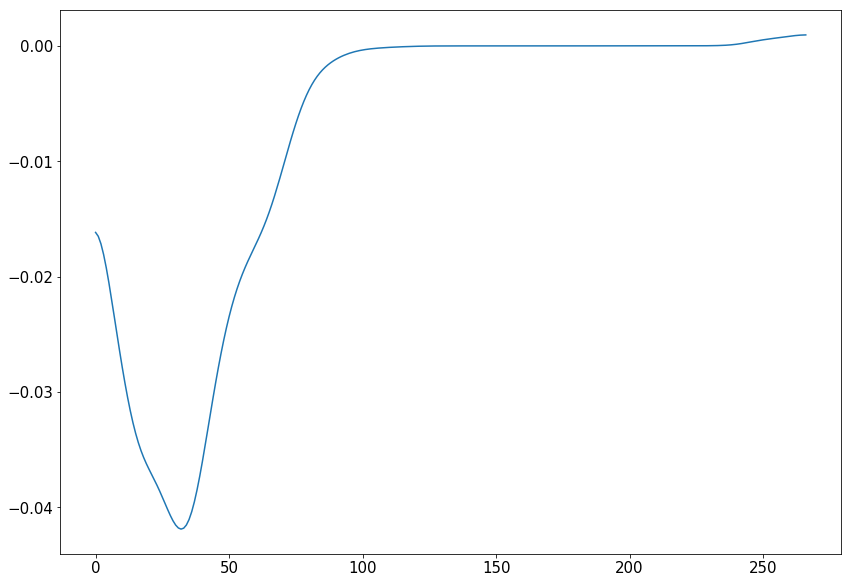

In [11]:
plt.plot(E_smooth[10,0])